In [1]:
## Importing libraries
from tqdm.notebook import tqdm as tqdm_notebook
import sys 
sys.path.append('/home/andrea/research/')
sys.path.append('.')
from utils_plotting import *
from utils_brain_analysis import *
from utils_analyse_HOtimeseries import find_frames_pctl,find_peaks
from utils_identifiability import *
from utils_neuromaps_brain import *
import pickle as pk
import os

In [2]:
path_yeoROIs='/home/andrea/miplabsrv2/HCP_misc/Misc/yeoOrder/yeo_RS7_Schaefer100S.mat'
HCP_path='/home/andrea/miplabsrv2/HCP/'
path_rest='../../Results/01_REST/'
path_data_saved='../../Results/02_data_saved/'

In [3]:
yeoROIs=np.array([i[0]-1 for i in loadmat(path_yeoROIs)['yeoROIs']])
yeoROIs=np.array([7 if x==8 else x for x in yeoROIs])
N_subjects=100
N_nodes=119
map_idx_triangles={val:idx for idx,val in enumerate(combinations(np.arange(N_nodes),3))}
N_triangles=len(map_idx_triangles)
edges_map={tuple(i):np.array([],dtype=int) for i in list(combinations(np.arange(119),2))}
N_edges=len(edges_map)

## Loading all data

In [4]:
def average_data_triangle(h5py_data):
    '''
    Average the violating triangle data across time
    
    Parameters
    ----------
    h5py_data: hd5 file
    The file contains the violating triangle data
    
    Returns
    -------
    The average of the violating triangle across time
    '''
    list_times=sorted(list(map(int,list(h5py_data.keys()))))
    T=len(list_times)
    N_triangles=len(h5py_data[str(list_times[0])])
    current_triangles = np.zeros((N_triangles,T))
    for t in list_times:
        current_triangles[:,t-1]=copy.deepcopy(h5py_data[str(t)][:])
    h5py_data.close()
    return(np.mean(np.abs(current_triangles),axis=1))


In [5]:
def average_data_scaffold(h5py_data):
    '''
    Average the scaffold data across time
    
    Parameters
    ----------
    h5py_data: hd5 file
    The file contains the scaffold data
    
    Returns
    -------
    The average of the scaffold data across time
    '''
    list_times=sorted(list(map(int,list(h5py_data.keys()))))
    T=len(list_times)
    N_edges=len(h5py_data[str(list_times[0])])
    current_scaffold = np.zeros((N_edges,N_edges))
    for t in list_times:
        current_scaffold+=copy.deepcopy(h5py_data[str(t)][:])
    h5py_data.close()
    current_scaffold/=T
    return(current_scaffold)


In [6]:
## Loading all the triangle data in a dictionary (heavy on RAM):
list_subjs=[i.split('/')[-1] for i in sorted(glob.glob(HCP_path+'*'))][:N_subjects]

if os.path.isfile(path_data_saved + 'data_triangles_REST.pkl'):
    data_triangles_REST = {}
    with open(path_data_saved + 'data_triangles_REST.pkl','rb+') as f:
        data_triangles_REST = pk.load(f)
else:
    data_triangles_REST={}
    for subjID in tqdm_notebook(list_subjs):
        for day in [1,2]:
            file_name=f'HO_triangles_{subjID}_REST{day}_LR.hd5'
            path_filename=path_rest+file_name
            print(path_filename)
            current_data=h5py.File(path_filename,'r')
            avg_triangle=average_data_triangle(current_data)
            data_triangles_REST[(subjID,day)]=avg_triangle
            
    with open(path_data_saved + 'data_triangles_REST.pkl','wb+') as f:
        pk.dump(data_triangles_REST,f)

In [6]:
## Loading all the Scaffold frequency results
list_subjs=[i.split('/')[-1] for i in sorted(glob.glob(HCP_path+'*'))][:N_subjects]
if os.path.isfile(path_data_saved + 'data_scaffold_REST.pkl'):
    data_scaffold_REST={}
    with open(path_data_saved+ 'data_scaffold_REST.pkl','rb+') as f:
        data_scaffold_REST=pk.load(f)
else:
    data_scaffold_REST={}
    for subjID in tqdm_notebook(list_subjs):
        for day in [1,2]:
            file_name=f'HO_scaffold_{subjID}_REST{day}_LR.hd5'
            path_filename=path_rest+file_name
            current_data=h5py.File(path_filename,'r')
            avg_scaffold=average_data_scaffold(current_data)
            data_scaffold_REST[(subjID,day)]=avg_scaffold
    with open(path_data_saved + 'data_scaffold_REST.pkl', 'wb+') as f:
        pk.dump(data_scaffold_REST,f)

In [8]:
## Loading all the BOLD and Edges time series
list_subjs=[i.split('/')[-1] for i in sorted(glob.glob(HCP_path+'*'))][:N_subjects]
if os.path.isfile(path_data_saved + 'data_BOLD_REST.pkl'):
    data_BOLD_REST={}
    with open(path_data_saved + 'data_BOLD_REST.pkl','rb+') as f:
        data_BOLD_REST=pk.load(f)
    data_edges_REST={}
    with open(path_data_saved + 'data_edges_REST.pkl','rb+') as f:
        data_edges_REST=pk.load(f)
else:
    data_BOLD_REST={}
    data_edges_REST={}
    for subjID in tqdm_notebook(list_subjs):
        for day in [1,2]:
            path_data=f'{HCP_path}{subjID}/rfMRI_REST{day}_LR/Schaefer100/TS_Schaefer100S_gsr_bp_z.mat'
            current_bold_data=sio.loadmat(path_data)['TS']
            current_edge_data=compute_eFC(current_bold_data)
            data_BOLD_REST[(subjID,day)]=np.corrcoef(current_bold_data)
            data_edges_REST[(subjID,day)]=current_edge_data
#     with open('data_BOLD_REST.pkl','wb+') as f:
#         pk.dump(data_BOLD_REST,f)
#     with open('data_edges_REST.pkl','wb+') as f:
#         pk.dump(data_edges_REST,f)

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
list_yeo_networks={'VIS':0,'SM':1,'DA':2,'VA':3,'L':4,'FP':5,'DMN':6,'SC':7,'ALL':10}
list_nodes_indexes={i:0 for i in list_yeo_networks}
list_nodes_edges_indexes={i:0 for i in list_yeo_networks}
list_nodes_triangles_indexes={i:0 for i in list_yeo_networks}
list_nodes_edgesFC_indexes={i:0 for i in list_yeo_networks}

for NET_selected in tqdm_notebook(list_yeo_networks): 
    if NET_selected != 'ALL':
        net_sel=list_yeo_networks[NET_selected] ## This is current Yeo network
        nodes_Yeonetwork=frozenset(np.where(yeoROIs==net_sel)[0])
        list_Yeonetwork_indexes_triangles=[]
        list_Yeonetwork_indexes_edges=[]
        #find the indices of triangles with at least one node in the current Yeo network
        for idx,l in enumerate(combinations(np.arange(N_nodes),3)):
            i,j,k=l
            if (i in nodes_Yeonetwork) or (j in nodes_Yeonetwork) or (k in nodes_Yeonetwork):
                list_Yeonetwork_indexes_triangles.append(idx)
        
        #find the indices of edges with at least one node in the current Yeo network
        for idx,l in enumerate(combinations(np.arange(N_nodes),2)):
            i,j=l
            if (i in nodes_Yeonetwork) or (j in nodes_Yeonetwork) or (k in nodes_Yeonetwork):
                list_Yeonetwork_indexes_edges.append(idx)
        list_Yeonetwork_indexes = np.array(list(nodes_Yeonetwork))
        
        #Find the indices of edges FC with at least one node in the current Yeo Network
        idx_all=0
        list_Yeonetwork_indexes_edgesFC=[]
        list_all_edges=list(combinations(np.arange(N_nodes),2))
        for idx_uv,l in tqdm_notebook(enumerate(list_all_edges)):
            for idx_wz,p in enumerate(list_all_edges[(idx_uv+1):]):
                u,v=l
                w,z=p
                flag=[u in nodes_Yeonetwork,v in nodes_Yeonetwork,w in nodes_Yeonetwork,z in nodes_Yeonetwork]
                flag_set=set([u,v,w,z])
                if sum(flag)>=1:
                    list_Yeonetwork_indexes_edgesFC.append(idx_all)
                idx_all+=1
        
    else:
        list_Yeonetwork_indexes_triangles=np.arange(N_triangles)
        list_Yeonetwork_indexes_edges=np.arange(N_edges)
        list_Yeonetwork_indexes = np.array(np.arange(N_nodes))
        list_Yeonetwork_indexes_edgesFC = np.array(np.arange(int(N_edges*(N_edges-1)/2)))
        
    list_Yeonetwork_indexes_triangles=np.array(list_Yeonetwork_indexes_triangles)
    list_Yeonetwork_indexes_edges=np.array(list_Yeonetwork_indexes_edges)

    list_nodes_indexes[NET_selected]=list_Yeonetwork_indexes
    list_nodes_edges_indexes[NET_selected]=list_Yeonetwork_indexes_edges
    list_nodes_edgesFC_indexes[NET_selected]=list_Yeonetwork_indexes_edgesFC
    list_nodes_triangles_indexes[NET_selected]=list_Yeonetwork_indexes_triangles

  0%|          | 0/9 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Setting the seed for reproducibility

In [10]:
random.seed(10)

In [11]:
### Creating the list of indexes that have a node of the triangle (i,j,k) in the X network
list_yeo_networks={'VIS':0,'SM':1,'DA':2,'VA':3,'L':4,'FP':5,'DMN':6, 'SC':7}

N_subjects_sample=80
results_all_fingerprinting_bootstrap_triangles={}
results_all_fingerprinting_bootstrap_scaffold={}
results_all_fingerprinting_bootstrap_eFC={}
results_all_fingerprinting_bootstrap_FC={}

MAX_BOOTSTRAP=100

list_subjs_all=[i.split('/')[-1] for i in sorted(glob.glob(HCP_path+'*'))][:N_subjects]
for l in tqdm_notebook(range(MAX_BOOTSTRAP)):
    list_subjs=random.sample(list_subjs_all,N_subjects_sample)
    for NET_selected in list_yeo_networks: 
        if NET_selected not in results_all_fingerprinting_bootstrap_triangles:
            results_all_fingerprinting_bootstrap_triangles[NET_selected]=[]
            results_all_fingerprinting_bootstrap_scaffold[NET_selected]=[]
            results_all_fingerprinting_bootstrap_eFC[NET_selected]=[]
            results_all_fingerprinting_bootstrap_FC[NET_selected]=[]
            
                        
        list_Yeonetwork_indexes=list_nodes_indexes[NET_selected]
        list_Yeonetwork_indexes_scaffold=list_nodes_indexes[NET_selected]
        list_Yeonetwork_indexes_edges=list_nodes_edges_indexes[NET_selected]
        list_Yeonetwork_indexes_edgesFC=list_nodes_edgesFC_indexes[NET_selected]
        list_Yeonetwork_indexes_triangles=np.array(list_nodes_triangles_indexes[NET_selected])
        
        ###Put the triangle avg activity in Test and Retest
        list_activities_T_BOLD=[]
        list_activities_R_BOLD=[]
        list_activities_T_Scaffold=[]
        list_activities_R_Scaffold=[]
    
        list_activities_T_edges=[]
        list_activities_R_edges=[]
        list_activities_T=[]
        list_activities_R=[]
        current_values_triangles=[]
        current_values_edges=[]
        current_values_Scaffold=[]
        current_values_BOLD=[]
        for subj in list_subjs:        
            list_activities_T_BOLD.append(data_BOLD_REST[(subj,1)][list_Yeonetwork_indexes,:].flatten())
            list_activities_R_BOLD.append(data_BOLD_REST[(subj,2)][list_Yeonetwork_indexes,:].flatten())

            list_activities_T_Scaffold.append(data_scaffold_REST[(subj,1)][list_Yeonetwork_indexes,:].flatten())
            list_activities_R_Scaffold.append(data_scaffold_REST[(subj,2)][list_Yeonetwork_indexes,:].flatten())

            list_activities_T_edges.append(upper_tri_masking(data_edges_REST[(subj,1)])[list_Yeonetwork_indexes_edgesFC])
            list_activities_R_edges.append(upper_tri_masking(data_edges_REST[(subj,2)])[list_Yeonetwork_indexes_edgesFC])       
            
            list_activities_T.append(data_triangles_REST[(subj,1)][list_Yeonetwork_indexes_triangles])
            list_activities_R.append(data_triangles_REST[(subj,2)][list_Yeonetwork_indexes_triangles])
        
        Idiff,Iself,Iothers=compute_Iself_Iothers_general(np.corrcoef(list_activities_T,list_activities_R)[0:N_subjects_sample,N_subjects_sample:])
        current_values_triangles.append([Idiff,Iself,Iothers]),
        current_values_triangles=np.array(current_values_triangles)
        results_all_fingerprinting_bootstrap_triangles[NET_selected].append(current_values_triangles)

        Idiff,Iself,Iothers=compute_Iself_Iothers_general(np.corrcoef(list_activities_T_edges,list_activities_R_edges)[0:N_subjects_sample,N_subjects_sample:])
        current_values_edges.append([Idiff,Iself,Iothers]),
        current_values_edges=np.array(current_values_edges)
        results_all_fingerprinting_bootstrap_eFC[NET_selected].append(current_values_edges)

        
        Idiff,Iself,Iothers=compute_Iself_Iothers_general(np.corrcoef(list_activities_T_Scaffold,list_activities_R_Scaffold)[0:N_subjects_sample,N_subjects_sample:])
        current_values_Scaffold.append([Idiff,Iself,Iothers]),
        current_values_Scaffold=np.array(current_values_Scaffold)
        results_all_fingerprinting_bootstrap_scaffold[NET_selected].append(current_values_Scaffold)
        
        Idiff,Iself,Iothers=compute_Iself_Iothers_general(np.corrcoef(list_activities_T_BOLD,list_activities_R_BOLD)[0:N_subjects_sample,N_subjects_sample:])
        current_values_BOLD.append([Idiff,Iself,Iothers]),
        current_values_BOLD=np.array(current_values_BOLD)
        results_all_fingerprinting_bootstrap_FC[NET_selected].append(current_values_BOLD)


  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
# with open(path_data_saved + 'results_all_fingerprinting_bootstrap_triangles_100bootstrap_80subj.pkl','wb+') as f:
#     pk.dump(results_all_fingerprinting_bootstrap_triangles,f)
    
# with open(path_data_saved + 'results_all_fingerprinting_bootstrap_eFC_100bootstrap_80subj.pkl','wb+') as f:
#     pk.dump(results_all_fingerprinting_bootstrap_eFC,f)
    
# with open(path_data_saved + 'results_all_fingerprinting_bootstrap_scaffold_100bootstrap_80subj.pkl','wb+') as f:
#     pk.dump(results_all_fingerprinting_bootstrap_scaffold,f)

# with open(path_data_saved + 'results_all_fingerprinting_bootstrap_FC_100bootstrap_80subj.pkl','wb+') as f:
#     pk.dump(results_all_fingerprinting_bootstrap_FC,f)


### Plotting the data

In [7]:
sys.path.append('/home/andrea/research/')
from utils_neuromaps_brain import *
import pickle as pk
N_nodes=119
N_subjects=100

In [8]:
#path='/home/andrea/miplabsrv2/COST/Project2_Higher_Order_Brain/Jupyter/'
with open(path_data_saved+'results_all_fingerprinting_bootstrap_triangles_100bootstrap_80subj.pkl','rb+') as f:
    results_all_fingerprinting_bootstrap_triangles=pk.load(f)
with open(path_data_saved+'results_all_fingerprinting_bootstrap_eFC_100bootstrap_80subj.pkl','rb+') as f:
    results_all_fingerprinting_bootstrap_eFC=pk.load(f)
with open(path_data_saved+'results_all_fingerprinting_bootstrap_scaffold_100bootstrap_80subj.pkl','rb+') as f:
    results_all_fingerprinting_bootstrap_Scaffold=pk.load(f)
with open(path_data_saved+'results_all_fingerprinting_bootstrap_FC_100bootstrap_80subj.pkl','rb+') as f:
    results_all_fingerprinting_bootstrap_FC=pk.load(f)
    


In [9]:
def plot_adjustments(ax=False, ticks_width=1.5, axis_width=2.5, labelsizereg=16,disable_top_right=False):
    if ax == False:
        ax = plt.gca()
    plt.rcParams['font.family'] = "PT Serif Caption"
    plt.rcParams['xtick.major.width'] = ticks_width
    plt.rcParams['ytick.major.width'] = ticks_width
    plt.rcParams['axes.linewidth'] = ticks_width
    if disable_top_right== True:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    ax.spines["top"].set_linewidth(axis_width)
    ax.spines["right"].set_linewidth(axis_width)
    ax.spines["left"].set_linewidth(axis_width)
    ax.spines["bottom"].set_linewidth(axis_width)
    ax.tick_params(direction='out', length=4, width=axis_width + 0.5, colors='k',
                   grid_color='k', grid_alpha=0.5, axis='both')
    ax.tick_params(direction='out', which='minor', length=6, width=axis_width + 0.5, colors='k',
                   grid_color='k', grid_alpha=0.5, axis='both')
    ax.tick_params(direction='out', which='major', length=6, colors='k',
                   grid_color='k', grid_alpha=0.5, axis='both')
    ax.tick_params(axis='both', which='major', labelsize=labelsizereg)

In [10]:
import matplotlib

matplotlib.font_manager._load_fontmanager(try_read_cache=False)

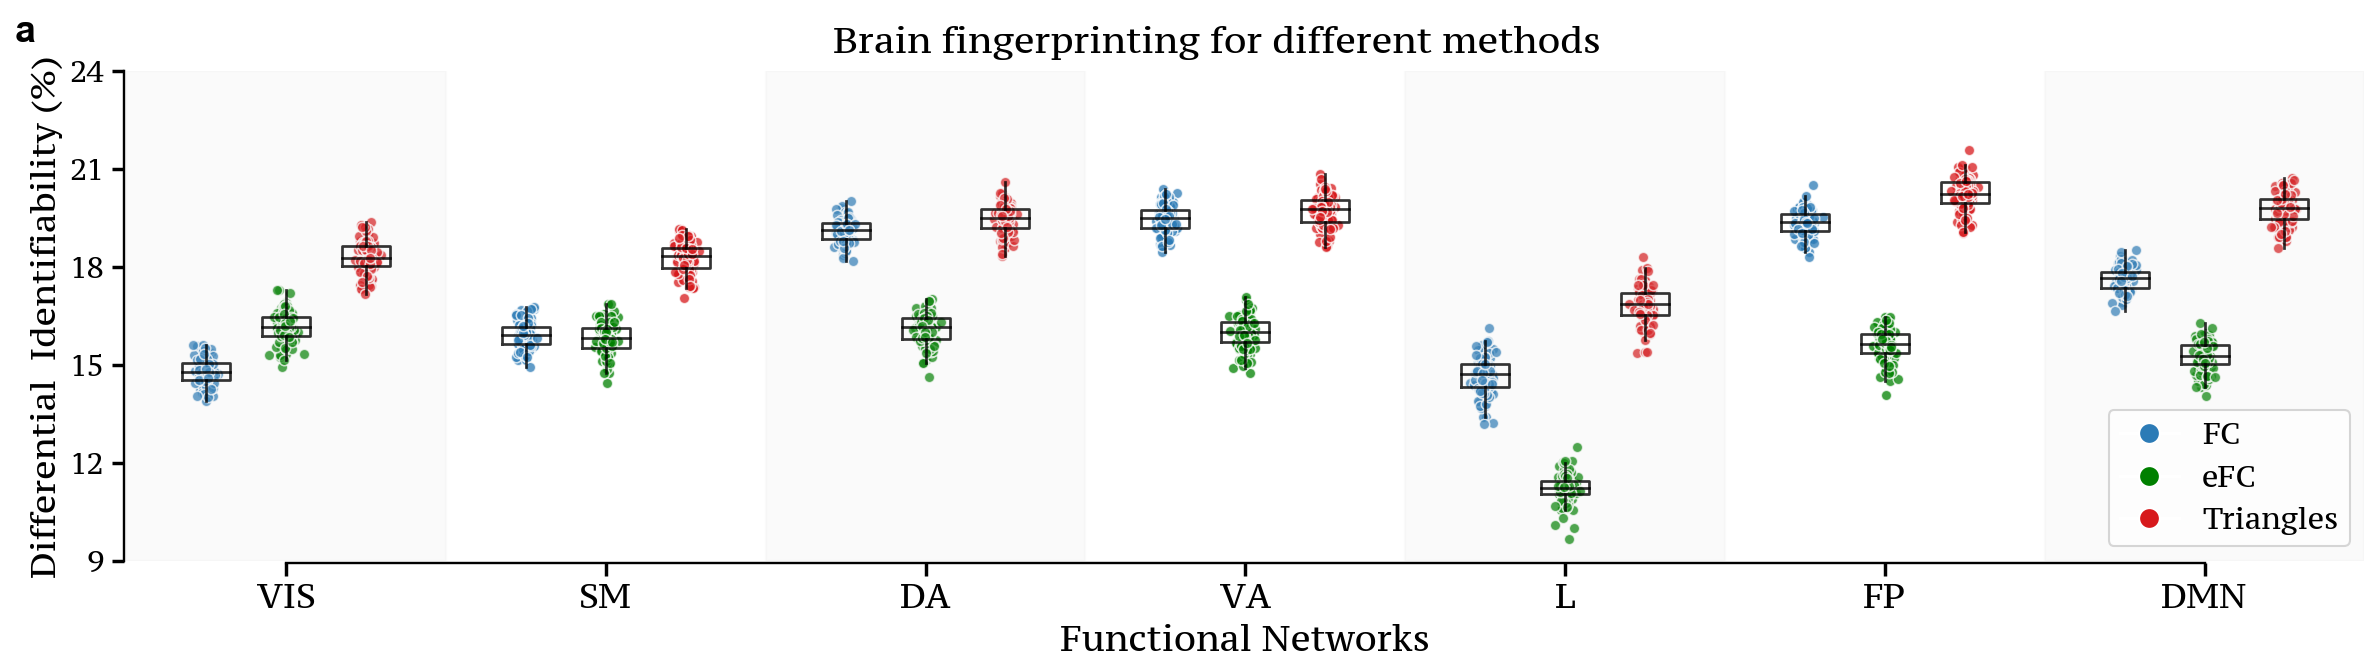

In [20]:
data_TRIANGLE = [list(np.array(results_all_fingerprinting_bootstrap_triangles[key])[:,0,0]) for key in ['VIS','SM','DA','VA','L','FP','DMN']]
data_EDGE = [list(np.array(results_all_fingerprinting_bootstrap_eFC[key])[:,0,0]) for key in ['VIS','SM','DA','VA','L','FP','DMN']]
data_NODE = [list(np.array(results_all_fingerprinting_bootstrap_FC[key])[:,0,0]) for key in ['VIS','SM','DA','VA','L','FP','DMN']]

ticks = ['VIS', 'SM', 'DA', 'VA', 'L', 'FP','DMN']

def set_box_color(bp, color, lw, alpha_box):
    plt.setp(bp['boxes'], color=color,linewidth=lw,alpha=alpha_box)
    plt.setp(bp['whiskers'], color=color,linewidth=lw,alpha=alpha_box)
    plt.setp(bp['caps'], color=color,linewidth=lw,alpha=alpha_box)
    plt.setp(bp['medians'], color=color,linewidth=lw,alpha=alpha_box)

fig = plt.figure(figsize=(15.6,4),dpi=150)
ax = plt.subplot(111)
plot_adjustments(ax=ax,ticks_width=1.15,axis_width=1.15,labelsizereg=14)
# plt.ylim(3,24)
plt.ylim(9,24)
plt.yticks(np.arange(9,24+0.1,3))
plt.xlim(-1,13)
sns.despine(fig,offset=1,trim=True)
width_box=0.3

# sns.stripplot(data=long_df,x='Network',y='Value',hue='Type',jitter=0.05,alpha=0.5)
bpl_nod= plt.boxplot(data_NODE, positions=np.array(np.arange(len(data_NODE)))*2.0-0.5, sym='',
                     widths=width_box, showfliers=False,showcaps=False)
bpl_edg = plt.boxplot(data_EDGE, positions=np.array(np.arange(len(data_EDGE)))*2.0, sym='',
                      widths=width_box, showfliers=False,showcaps=False)
bpl_tri = plt.boxplot(data_TRIANGLE, positions=np.array(np.arange(len(data_TRIANGLE)))*2.0+0.5, sym='',
                      widths=width_box, showfliers=False,showcaps=False)

alpha_val=0.75
size_marker=25
lw_box=1.3
for l in range(7):
    #Triangle points
    plt.scatter(np.random.normal(2*l-0.5,0.03,size=len(data_NODE[l])),data_NODE[l],
            s=size_marker,color='#2C7BB6',alpha=alpha_val,zorder=-100,marker='o', edgecolor='white',linewidth=0.75)

    plt.scatter(np.random.normal(2*l,0.03,size=len(data_EDGE[l])),data_EDGE[l],
                s=size_marker,color='green',alpha=alpha_val,zorder=-100,marker='o', edgecolor='white',linewidth=0.75)

    plt.scatter(np.random.normal(2*l+0.5,0.03,size=len(data_TRIANGLE[l])),data_TRIANGLE[l],
                s=size_marker,color='#D7191C',alpha=alpha_val,zorder=-100,marker='o', edgecolor='white',linewidth=0.75)
    


alpha_box=0.8
set_box_color(bpl_tri, 'black',lw_box,alpha_box) # colors are from http://colorbrewer2.org/
set_box_color(bpl_edg, 'black',lw_box,alpha_box)
set_box_color(bpl_nod, 'black',lw_box,alpha_box)

line1 = Line2D([], [], color="white", marker='o', markersize=10, markerfacecolor="#D7191C")
line2 = Line2D([], [], color="white", marker='o', markersize=10, markerfacecolor="green")
line3 = Line2D([], [], color="white", marker='o', markersize=10, markerfacecolor="#2C7BB6")
plt.legend((line3,line2, line1), ('FC','eFC', 'Triangles'),
           numpoints=1, fontsize=14,ncol=1,loc='lower right')

plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks,fontsize=16)
# plt.xlim(-2, len(ticks)*2)
# plt.ylim(0, 8)
plt.tight_layout()
plt.suptitle('Brain fingerprinting for different methods',y=1.02,fontsize=17.5)
plt.xlabel('Functional Networks',fontsize=17)
plt.ylabel('Differential  Identifiability (%)',fontsize=16.5,labelpad=3)
ax.axvspan(-1,1, alpha=0.1, color='lightgray')

ax.axvspan(3,5, alpha=0.1, color='lightgray')
ax.axvspan(7,9, alpha=0.1, color='lightgray')
ax.axvspan(11,13, alpha=0.1, color='lightgray')
# matplotlib.rcParams['font.sans-serif'] = "Arial"
#Then, "ALWAYS use sans-serif fonts"
#matplotlib.rcParams['font.family'] = "sans-serif"

font = {'family': 'sans-serif',
        'fontname':'Arial',
        'color':  'black',
        'weight': 'bold',
        'size': 18,
        }


plt.text(x=-0.045,y=1.08,s="a", horizontalalignment='center',
     verticalalignment='center',clip_on=False,weight='bold',fontdict=font,
     transform = ax.transAxes)

bars = np.arange(-0.5,13,0.5)
heights = [21]*len(bars)

# barplot_annotate_brackets(0,1,.01, bars, heights,barh=0.01)
plt.savefig(path_data_saved + 'Fig4_Brain_fingerprinting_top_panel_final.svg')

### Second part of the plot

In [12]:
list_yeo_networks={'VIS':0,'SM':1,'DA':2,'VA':3,'L':4,'FP':5,'DMN':6}
brain_map_triangles={i:[] for i in ['VIS','SM','DA','VA','L','FP','DMN']}
##Loading the yeoROIS
yeoROIs=np.array([i[0]-1 for i in loadmat(path_yeoROIs)['yeoROIs']])
map_idx_triangles={val:idx for idx,val in enumerate(combinations(np.arange(N_nodes),3))}

brain_map_triangles_Yeo_NET={i:[] for i in ['VIS','SM','DA','VA','L','FP','DMN']}


for NET_selected in tqdm_notebook(['VIS','SM','DA','VA','L','FP','DMN']):
    for flag_num in [1]:
        net_sel=list_yeo_networks[NET_selected] ## This is current Yeo network
        nodes_Yeonetwork=frozenset(np.where(yeoROIs==net_sel)[0])
        list_Yeonetwork_indexes_triangles=[]
        list_Yeonetwork_indexes_edges=[]
        #find the indices of triangles with at least one node in the current Yeo network
        indices_nodes={i:[] for i in range(N_nodes)}
        for idx,l in enumerate(combinations(np.arange(N_nodes),3)):
            i,j,k=l
            flag=[i in nodes_Yeonetwork,j in nodes_Yeonetwork, k in nodes_Yeonetwork]
            if sum(flag)>=flag_num:
                list_Yeonetwork_indexes_triangles.append(idx)
                indices_nodes[i].append(idx)
                indices_nodes[j].append(idx)
                indices_nodes[k].append(idx)
        data_network=[]
        for subjID in list_subjs:
            for j in [1,2]:
                current_data=np.nan_to_num(np.array([np.mean(data_triangles_REST[(subjID,j)][indices_nodes[i]]) for i in range(100)]))
                data_network.append(current_data)
        data_network=np.array(data_network)
        current_net=np.nan_to_num(np.std(data_network,axis=0)/np.mean(data_network,axis=0))
        brain_map_triangles[NET_selected].append(current_net)
#     brain_map_triangles[NET_selected]=np.corrcoef(np.array(brain_map_triangles[NET_selected]))
    ##Remap the brain maps at 7 yeo networks 
    for kk in ['VIS','SM','DA','VA','L','FP','DMN']:
        current_nodes_kk=np.array(list(frozenset(np.where(yeoROIs==list_yeo_networks[kk])[0])))
        brain_map_triangles_Yeo_NET[NET_selected].append(np.mean(brain_map_triangles[NET_selected][0][current_nodes_kk]))


  0%|          | 0/7 [00:00<?, ?it/s]

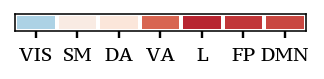

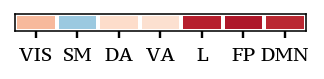

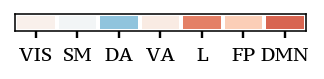

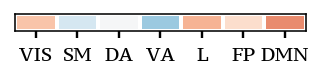

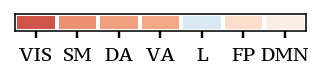

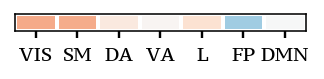

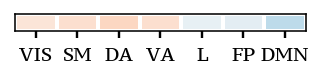

In [13]:
for net in ['VIS','SM','DA','VA','L','FP','DMN']:
    fig=plt.figure(dpi=150,figsize=(2.5,0.15))
    ax=plt.subplot(111)
    res=sns.heatmap([brain_map_triangles_Yeo_NET[net]],cmap='RdBu_r',vmin=0,vmax=0.4,cbar=False,linewidths = 1,
                  linecolor = "white")
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.75)
    ax.set_yticks([]);
    ax.set_xticklabels(['VIS','SM','DA','VA','L','FP','DMN'],fontsize=9);
    ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
    plt.savefig(path_data_saved + 'fingerprinting_YeoMap_CoefficientVariation_network_%s.svg'%net,transparent=True)

In [14]:
list_yeo_networks={'VIS':0,'SM':1,'DA':2,'VA':3,'L':4,'FP':5,'DMN':6}
brain_map_triangles={i:[] for i in ['VIS','SM','DA','VA','L','FP','DMN']}
##Loading the yeoROIS
map_idx_triangles={val:idx for idx,val in enumerate(combinations(np.arange(N_nodes),3))}



for NET_selected in tqdm_notebook(['VIS','SM','DA','VA','L','FP','DMN']):
    for flag_num in [1,2,3]:
        net_sel=list_yeo_networks[NET_selected] ## This is current Yeo network
        nodes_Yeonetwork=frozenset(np.where(yeoROIs==net_sel)[0])
        list_Yeonetwork_indexes_triangles=[]
        list_Yeonetwork_indexes_edges=[]
        #find the indices of triangles with at least one node in the current Yeo network
        indices_nodes={i:[] for i in range(N_nodes)}
        for idx,l in enumerate(combinations(np.arange(N_nodes),3)):
            i,j,k=l
            flag=[i in nodes_Yeonetwork,j in nodes_Yeonetwork, k in nodes_Yeonetwork]
            if sum(flag)==flag_num:
                list_Yeonetwork_indexes_triangles.append(idx)
                indices_nodes[i].append(idx)
                indices_nodes[j].append(idx)
                indices_nodes[k].append(idx)
        data_network=[]
        for subjID in list_subjs:
            for j in [1,2]:
                current_data=np.nan_to_num(np.array([np.mean(data_triangles_REST[(subjID,j)][indices_nodes[i]]) for i in range(100)]))
                data_network.append(current_data)
        data_network=np.array(data_network)
        current_net=np.nan_to_num(np.std(data_network,axis=0)/np.mean(data_network,axis=0))
        brain_map_triangles[NET_selected].append(current_net)
    brain_map_triangles[NET_selected]=np.corrcoef(np.array(brain_map_triangles[NET_selected]))

  0%|          | 0/7 [00:00<?, ?it/s]

/home/andrea/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andrea/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-14-8f4d17708bb3>:30: RuntimeWarning: invalid value encountered in true_divide
  current_net=np.nan_to_num(np.std(data_network,axis=0)/np.mean(data_network,axis=0))


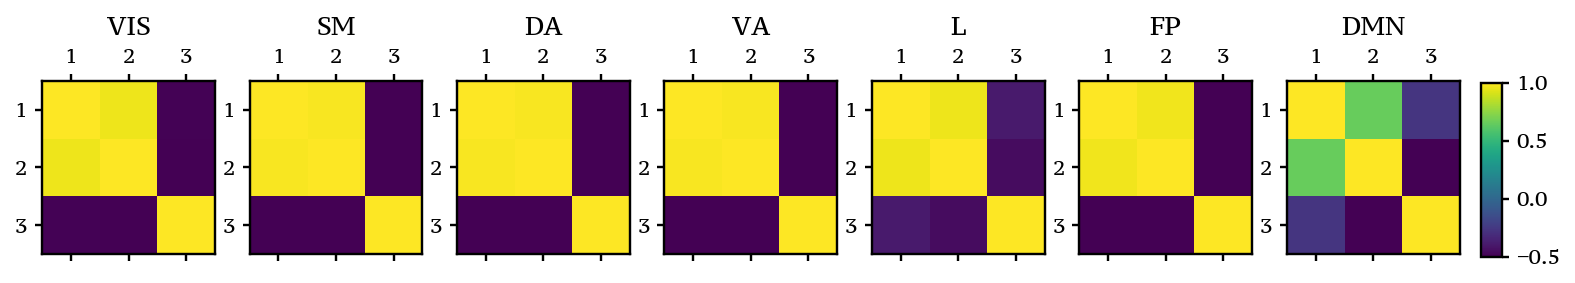

In [15]:
fig=plt.figure(figsize=(14,2),dpi=150)

for idx,i in enumerate(brain_map_triangles):
    ax=plt.subplot(int('17%d'%(idx+1)))
    
    cax=ax.matshow(brain_map_triangles[i],vmin=-0.5,vmax=1)
    ax.set_xticks(np.arange(len([1,2,3]), step=1))
    ax.set_yticks(list(range(0,len([1,2,3]))))
    ax.set_xticklabels([1,2,3])
    ax.set_yticklabels([1,2,3])
    
    plt.title(i)
#     if idx ==6:
#         fig.colorbar(cax)
#         plt.colorbar()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.205, 0.01, 0.58])
fig.colorbar(cax, cax=cbar_ax)
fig.set_label('Pearson')
# ax.cax.colorbar(cax)
# ax.cax.toggle_label(True)


In [16]:
NET_selected='DMN'
net_sel=list_yeo_networks[NET_selected] ## This is current Yeo network
nodes_Yeonetwork=frozenset(np.where(yeoROIs==net_sel)[0])
list_Yeonetwork_indexes_triangles=[]
list_Yeonetwork_indexes_edges=[]
#find the indices of triangles with at least one node in the current Yeo network
indices_nodes={i:[] for i in range(N_nodes)}
for idx,l in enumerate(combinations(np.arange(N_nodes),3)):
    i,j,k=l
    flag=[i in nodes_Yeonetwork,j in nodes_Yeonetwork, k in nodes_Yeonetwork]
    if sum(flag)>=1:
        list_Yeonetwork_indexes_triangles.append(idx)
        indices_nodes[i].append(idx)
        indices_nodes[j].append(idx)
        indices_nodes[k].append(idx)
        

In [17]:
data_network=[]
for subjID in list_subjs:
    for j in [1,2]:
        current_data=np.nan_to_num(np.array([np.mean(data_triangles_REST[(subjID,j)][indices_nodes[i]]) for i in range(100)]))
        data_network.append(current_data)
data_network=np.array(data_network)

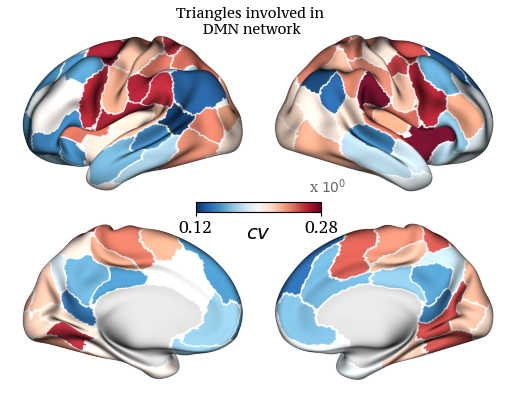

In [18]:
normal_view(np.nan_to_num(np.std(data_network,axis=0)/np.mean(data_network,axis=0)),edges=True,graymap_rev=False,
            alpha_graymap=0.99,center_cbar=True,xlabel='$cv$');
plt.suptitle('Triangles involved in\n %s network'% NET_selected,y=0.55,fontsize=14,)
# plt.tight_layout(pad=0)
plt.savefig(path_data_saved + 'fingerprinting_brainmap_CoefficientVariation_network_%s.svg'%NET_selected)

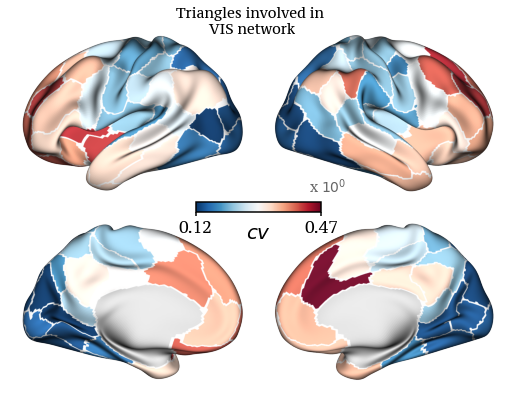

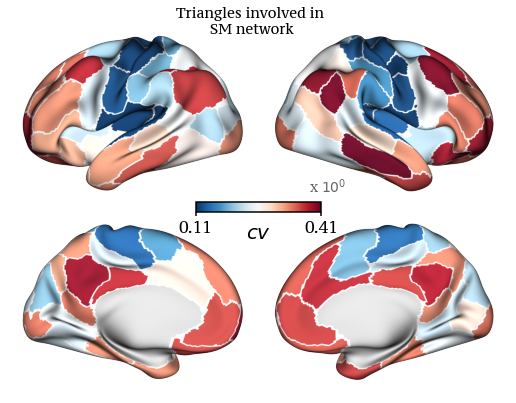

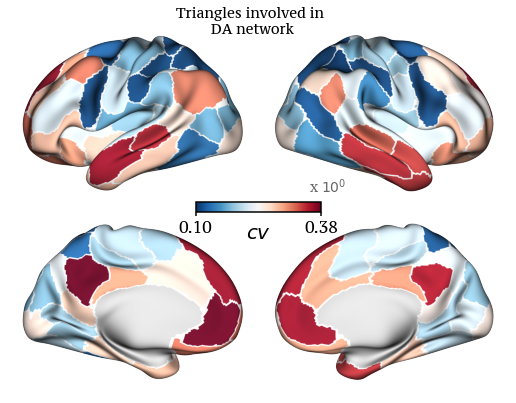

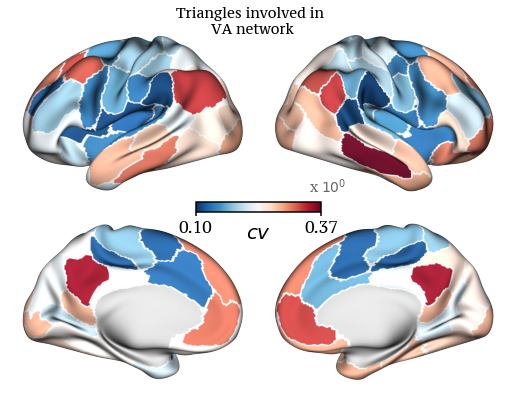

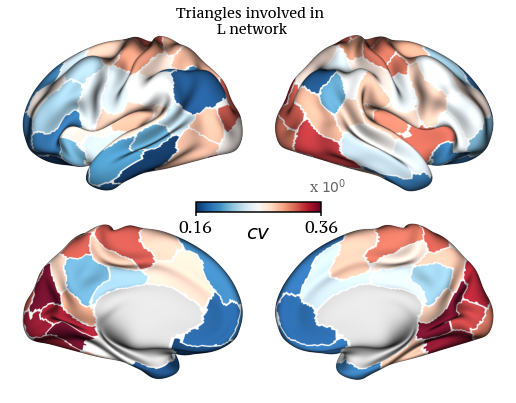

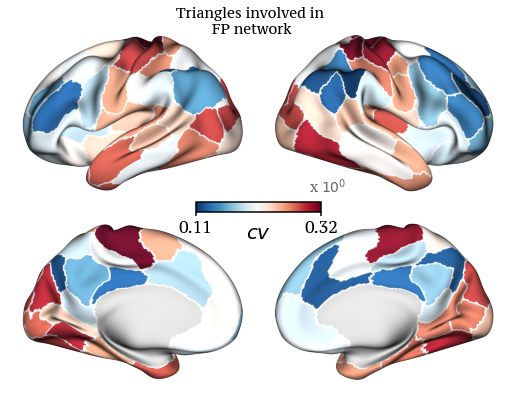

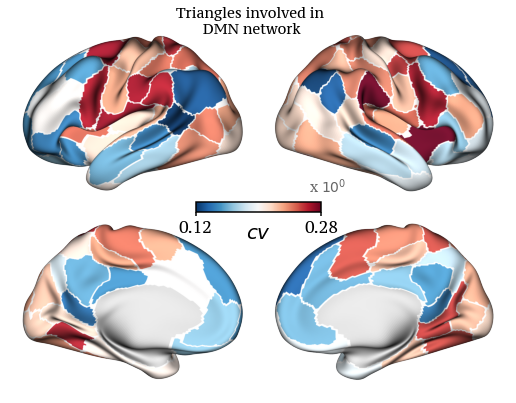

In [19]:
### All networks:
for NET_selected in ['VIS','SM','DA','VA','L','FP','DMN']:
    net_sel=list_yeo_networks[NET_selected] ## This is current Yeo network
    nodes_Yeonetwork=frozenset(np.where(yeoROIs==net_sel)[0])
    list_Yeonetwork_indexes_triangles=[]
    list_Yeonetwork_indexes_edges=[]
    #find the indices of triangles with at least one node in the current Yeo network
    indices_nodes={i:[] for i in range(N_nodes)}
    for idx,l in enumerate(combinations(np.arange(N_nodes),3)):
        i,j,k=l
        flag=[i in nodes_Yeonetwork,j in nodes_Yeonetwork, k in nodes_Yeonetwork]
        if sum(flag)>=1:
            list_Yeonetwork_indexes_triangles.append(idx)
            indices_nodes[i].append(idx)
            indices_nodes[j].append(idx)
            indices_nodes[k].append(idx)
            
    data_network=[]
    for subjID in list_subjs:
        for j in [1,2]:
            current_data=np.nan_to_num(np.array([np.mean(data_triangles_REST[(subjID,j)][indices_nodes[i]]) for i in range(100)]))
            data_network.append(current_data)
    data_network=np.array(data_network)
    normal_view(np.nan_to_num(np.std(data_network,axis=0)/np.mean(data_network,axis=0)),edges=True,graymap_rev=False,
            alpha_graymap=0.99,center_cbar=True,xlabel='$cv$');
    plt.suptitle('Triangles involved in\n %s network'% NET_selected,y=0.55,fontsize=14,)
    # plt.tight_layout(pad=0)
    plt.savefig(path_data_saved + 'fingerprinting_brainmap_CoefficientVariation_network_%s.svg'%NET_selected)